In [106]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [107]:
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression as LinearRegression_S
from sklearn.linear_model import Ridge

In [108]:
train_dataset_path = "/content/gdrive/MyDrive/Dataset for PRML PA1/Dataset1/train8.csv"
test_dataset_path = "/content/gdrive/MyDrive/Dataset for PRML PA1/Dataset1/test8.csv"

train_dataset = pd.read_csv(train_dataset_path, header=None)
test_dataset = pd.read_csv(test_dataset_path, header=None)

In [109]:
dataset = train_dataset.iloc[:,:].values
np.random.shuffle(dataset)

# training data 
train_X = dataset[0:55, 0:2]
train_Y = dataset[0:55, 2]
# validation data
valid_X = dataset[55:,0:2]
valid_Y = dataset[55:,2]

# test cases
test_X = test_dataset.iloc[:, 0:2].values
test_Y = test_dataset.iloc[:, 2].values

## Polynomial Regression

The first two columns of the training dataset appears to be the features of X and the third column is the value of Y.

Simple linear regresssion taking the loss function as "Mean Squared Error" has the answer to be $\beta = (X^TX)^{-1}XY$. Simply inputting that as the function, we would have final answer.

In [ ]:
def feature_normalise(X, bias=True):
  # remove the bias
  if bias:
    X = X[:, 1:]
  mean = np.mean(X, axis=0)
  mu = np.std(X, axis=0)
  X_norm = (X - mean)/mu
  if bias:
    X_norm = np.insert(X_norm , 0, 1, axis=1)
  return X_norm, mean, mu

def mean_squared_error( y_train, y_pred):
  diff = y_train - y_pred
  return np.mean(diff.dot(diff))

def plot_scatter(X, Y, pred, deg):
  ax = plt.axes(projection = "3d")
  ax.scatter(X[:,0], X[:, 1], Y, cmap='viridis', edgecolor='green')
  ax.scatter(X[:,0], X[:, 1], pred, cmap='viridis', edgecolor='purple')
  ax.set_title('Scatter Plot: Deg = '+str(deg))
  plt.show()

class LinearRegression:
  def __init__(self):
    self.weights = None
    self.deg = None
    self.y_mean = None

  def get_X(self, X):
    f = lambda x,i : x**i
    L = []
    for i in range(0, X.shape[0]):
        r = [f(X[i][0], k) for k in range(self.deg+1)]
        l = [f(X[i][1], k) for k in range(self.deg+1)]
        r = np.array(r)
        l = np.array(l)
        # b = list()
        # b.append(1)
        # for i in range(self.deg):
        #     b.append(r[i])
        #     b.append(l[i])
        r = r.reshape((self.deg+1,1))@l.reshape((1,self.deg+1))
        l = list()
        for j in range(r.shape[0]):
          for k in range(r.shape[1]):
            if(j+k < r.shape[0]):
              l.append(r[j][k])
        L.append(l)
    L = np.array(L)
    return L

  def fit(self, Z, W, deg):
    self.deg = deg
    X = self.get_X(Z)
    # find pseudo inverse
    pseudo_inverse = np.linalg.pinv(X)
    #multiply it with Y
    self.weights = pseudo_inverse@W
    return self.weights

  def predict(self, Z):
    X = self.get_X(Z)
    return X@self.weights

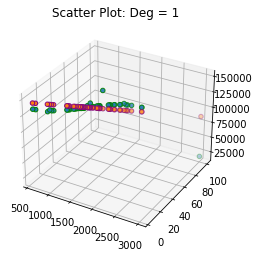

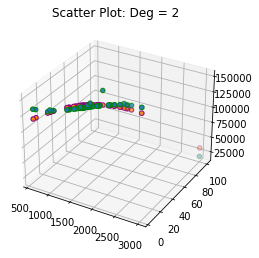

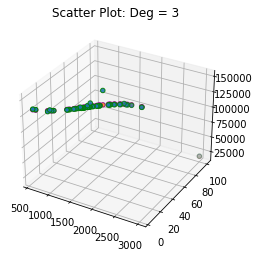

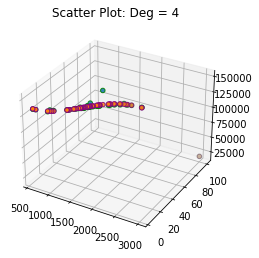

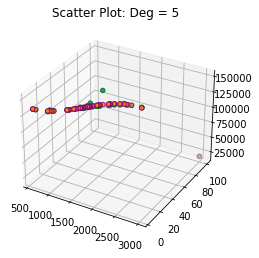

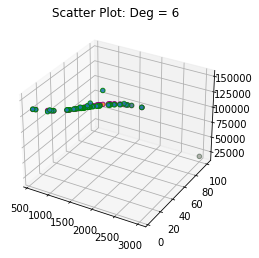

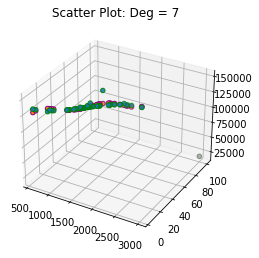

In [ ]:
lr = LinearRegression()
train_mse = list()
validation_mse = list()
till_deg = 8;
for deg in range(1,till_deg):
  w = lr.fit(train_X, train_Y, deg)
  y_pred = lr.predict(train_X)
  #mod_X = lr.get_X(train_X)
  #reg = LinearRegression_S().fit(mod_X, train_Y)
  #sk_pred = reg.predict(mod_X)
  y_valid_pred = lr.predict(valid_X)
  train_mse.append(mean_squared_error(train_Y, y_pred))
  validation_mse.append(mean_squared_error(valid_Y, y_valid_pred))
  plot_scatter(train_X, train_Y, y_pred, deg)
  #plot_scatter(train_X, train_Y, sk_pred, deg)
  # plot_scatter(train_X, train_Y, sk_pred, deg)
  # print(y_pred)
  # print(train_Y)

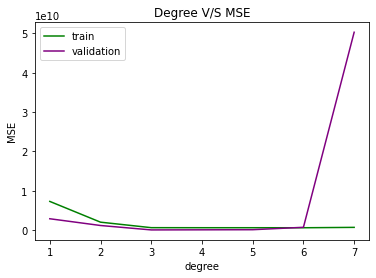

In [ ]:
plt.plot(np.arange(1,till_deg), train_mse, label='train', color='green')
plt.plot(np.arange(1,till_deg), validation_mse,label='validation', color='purple')
plt.xlabel('degree')
plt.ylabel('MSE')
plt.title('Degree V/S MSE')
plt.legend()
plt.show()

In [ ]:
min_err = np.min(validation_mse)
min_deg = np.argmin(validation_mse)+1
print(min_err, min_deg)

20544719.647576723 3


### Best Model is with DEG = 3

In [ ]:
# Error
w = lr.fit(train_X, train_Y, 3)
y_pred = lr.predict(train_X)
mean_squared_error(train_Y, y_pred)

592494636.008799

In [ ]:
y_test_pred = lr.predict(test_X)
mean_squared_error(test_Y, y_test_pred)

20014971.76918808

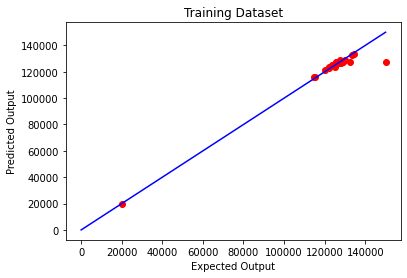

In [ ]:
plt.plot([0,np.max(train_Y)], [0,np.max(train_Y)], 'blue')
plt.scatter(train_Y, y_pred, color='red')
plt.xlabel('Expected Output')
plt.ylabel('Predicted Output')
plt.title('Training Dataset')
plt.show()

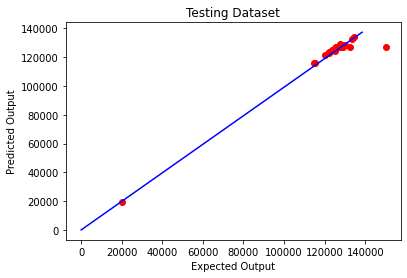

In [ ]:
plt.plot([0,np.max(test_Y)], [0,np.max(y_test_pred)], 'blue')
plt.scatter(train_Y, y_pred, color='red')
plt.xlabel('Expected Output')
plt.ylabel('Predicted Output')
plt.title('Testing Dataset')
plt.show()

Training dataset plot


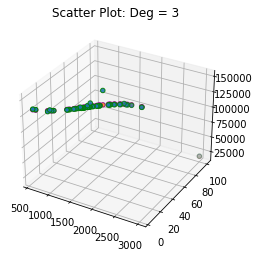

Testing dataset plot


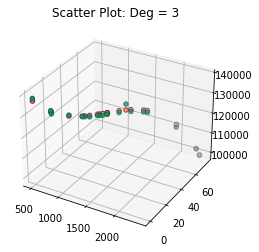

In [ ]:
print("Training dataset plot")
plot_scatter(train_X, train_Y, y_pred, 3)
print("Testing dataset plot")
plot_scatter(test_X, test_Y, y_test_pred, 3)

## Ridge Regression

In [110]:
# we get the best fit model from polynomial regression
w = lr.fit(train_X, train_Y, 7)
mod_X = lr.get_X(train_X)

In [111]:
class RidgeRegression:
  def __init__(self):
    self.weights = None
  def set_lambda(self, l):
    self.l = l
  def fit(self, X, Y):
    # normalise the values
    X, _, _ = feature_normalise(X)
    # Y, self.y_mean, self.y_sigma = feature_normalise(Y, bias=False) 
    inv = np.linalg.inv(X.T@X + self.l*np.identity(len(X.T)))@X.T
    self.weights = inv@Y
    return self.weights
  def predict(self, X):
    X, _, _ = feature_normalise(X)
    return (X@self.weights)

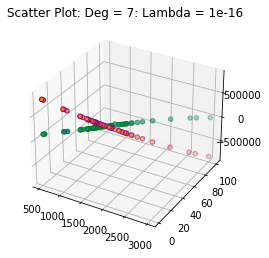

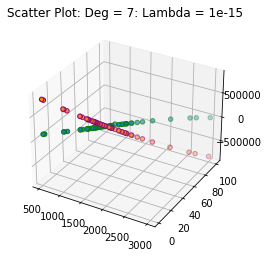

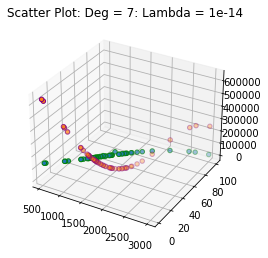

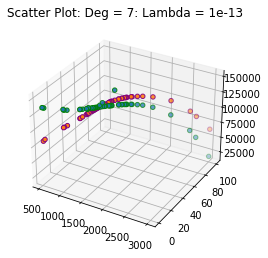

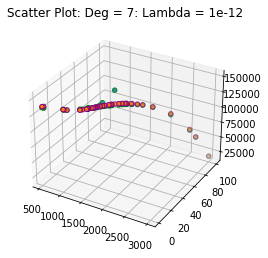

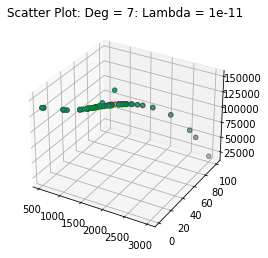

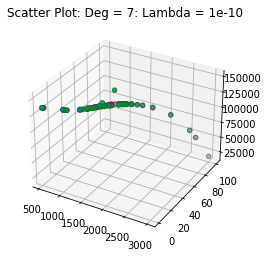

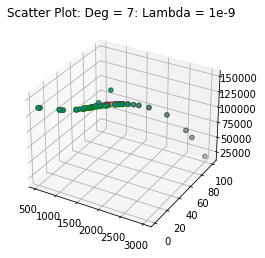

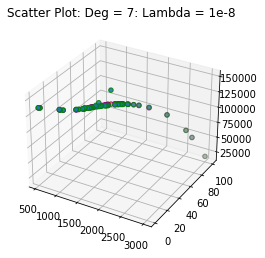

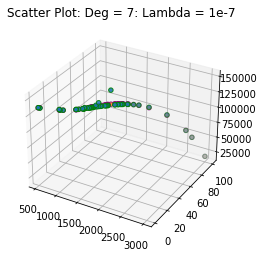

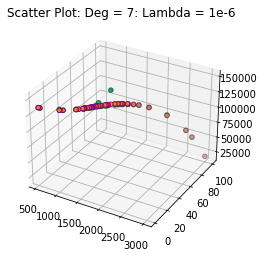

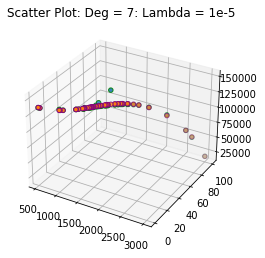

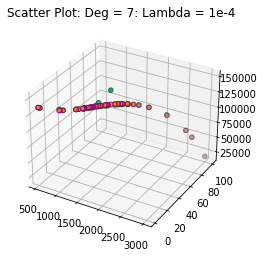

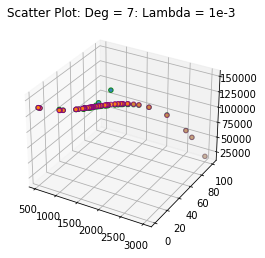

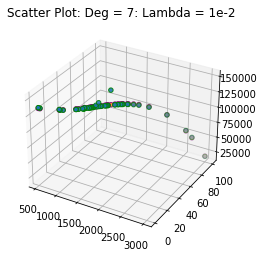

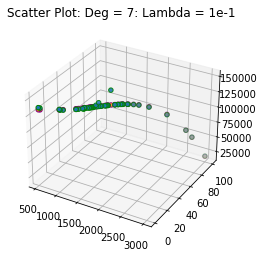

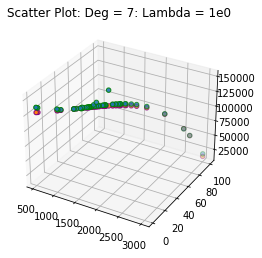

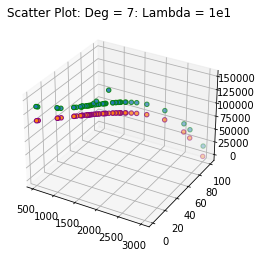

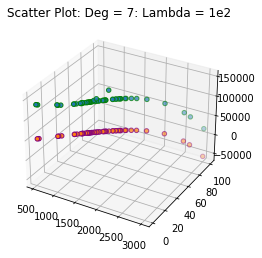

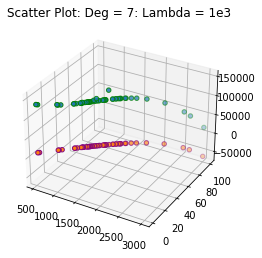

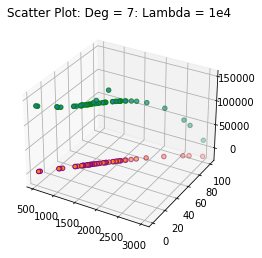

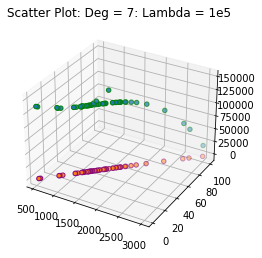

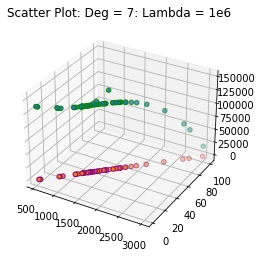

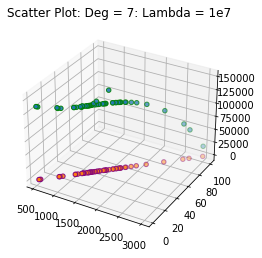

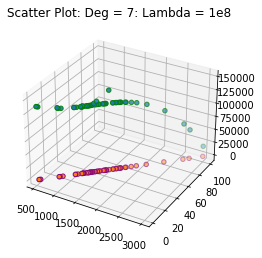

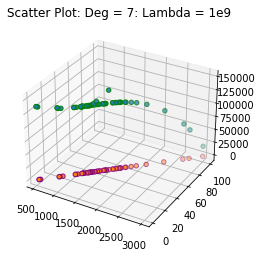

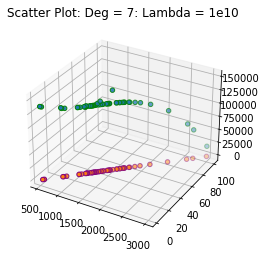

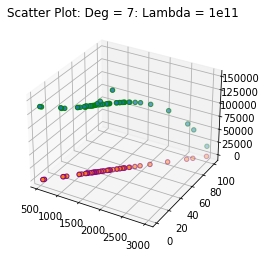

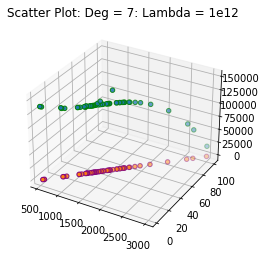

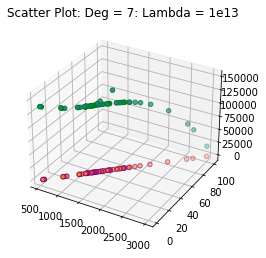

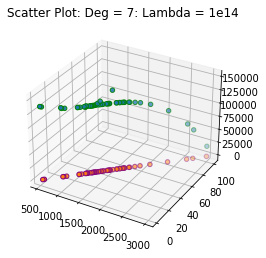

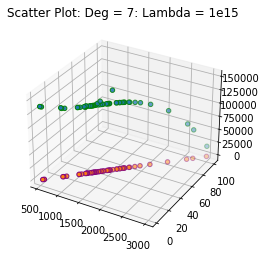

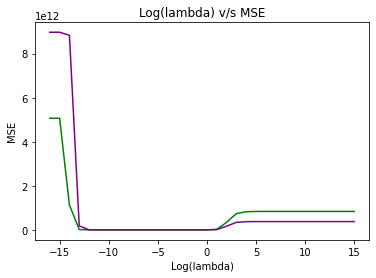

In [128]:
rr = RidgeRegression()
lam = []
err_vals = []
err_valid_vals = []
l = -16
mod_valid_X  = lr.get_X(valid_X)
while l < 16:
  rr.set_lambda(10**l)
  weights = rr.fit(mod_X, train_Y)
  y_pred = rr.predict(mod_X)
  y_valid_pred = rr.predict(mod_valid_X)
  plot_scatter(train_X, train_Y, y_pred, '7: Lambda = 1e'+str(l))
  err = mean_squared_error(train_Y, y_pred)
  err_valid = mean_squared_error(valid_Y, y_valid_pred)
  err_vals.append(err)
  err_valid_vals.append(err_valid)
  lam.append(l)
  l = l+1

plt.xlabel("Log(lambda)")
plt.ylabel("MSE")
plt.title("Log(lambda) v/s MSE")
plt.plot(lam, err_vals, color="green", label="Training")
plt.plot(lam, err_valid_vals, color="purple", label= "Validation")
plt.show()

In [123]:
# finding minimum MSE in validation dataset
min_err = np.min(err_valid_vals)
min_lambda = lam[np.argmin(err_valid_vals)]
print(min_err, min_lambda)

5542239756.007525 -12


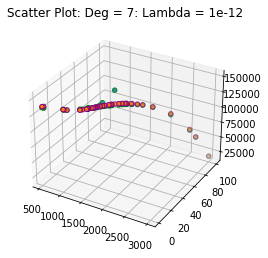

In [133]:
rr.set_lambda(10**-12)
w = rr.fit(mod_X, train_Y)
y_pred = rr.predict(mod_X)
plot_scatter(train_X, train_Y, y_pred, '7: Lambda = 1e-12')

In [134]:
mean_squared_error(train_Y, y_pred)

584435341.1201459

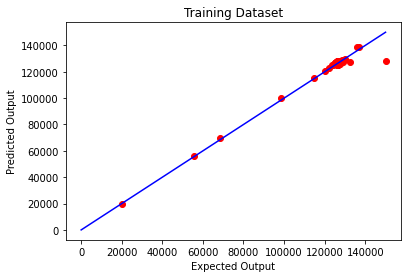

In [135]:
plt.plot([0,np.max(train_Y)], [0,np.max(train_Y)], 'blue')
plt.scatter(train_Y, y_pred, color='red')
plt.xlabel('Expected Output')
plt.ylabel('Predicted Output')
plt.title('Training Dataset')
plt.show()

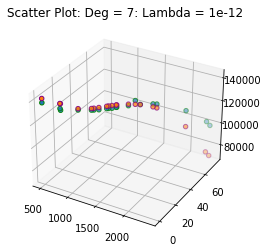

In [136]:
mod_test_X = lr.get_X(test_X)
rr.set_lambda(10**-12)
w = rr.fit(mod_X, train_Y)
y_pred = rr.predict(mod_test_X)
plot_scatter(test_X, test_Y, y_pred, '7: Lambda = 1e-12')

In [137]:
mean_squared_error(test_Y, y_pred)

1869058295.1067886

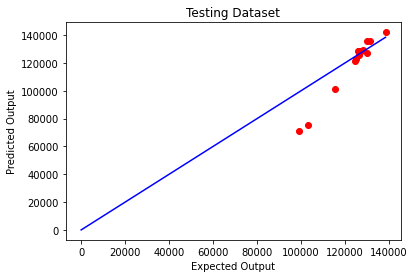

In [138]:
plt.plot([0,np.max(test_Y)], [0,np.max(test_Y)], 'blue')
plt.scatter(test_Y, y_pred, color='red')
plt.xlabel('Expected Output')
plt.ylabel('Predicted Output')
plt.title('Testing Dataset')
plt.show()

The minimum error found for ridge regression is $10028533872.658371$ at $\lambda=0.001$, which is better than what we found for simple linear regression.

## LASSO regression

Unlike ridge regression, there is no closed form expression for the weights for lasso regression. To combat this, we would have to perform gradient descent.

The loss function in LASSO regression is:
$$L(\beta;X,Y,\lambda) = \frac{1}{2}(y-X\beta)^T(y-X\beta) + \lambda||\beta||_1$$

In [ ]:
class LassoRegression:
  def __init__(self):
    self.weights = None
  def set_lambda(self, l):
    self.l = l
  def grad(self, X, Y):
    Y_pred = self.predict(X)
    dW = -2*(X.T@np.subtract(Y,Y_pred))
    for x in self.weights[1:]:
      if x < 0:
        dW -= self.l
      else:
        dW += self.l

    # print("hi",dW)
    return dW
    
    
  def fit(self, X, Y, learning_rate=0.002, num_iter=1000):
    X, _, _ = feature_normalise(X)
    # There is no closed form solution for lasso regression. So, we would have to perform gradient descent.
    self.weights = np.random.rand(X.shape[1])
    print(self.weights)

    for iter in range(num_iter):
      self.weights -= learning_rate*self.grad(X, Y)

  def predict(self, X):
    return np.matmul(X, self.weights)



(79,)
[0.49961723 0.07217591 0.4583233 ]
[0.49733674 0.86885769 0.26630906]
[0.24991366 0.04686958 0.15122997]
[0.13467295 0.56489881 0.26579248]
[0.71590011 0.3781598  0.55489416]
[0.5976903  0.31400104 0.34907979]
[0.63580287 0.94447831 0.87727128]
[0.96489201 0.29004195 0.66180957]
[0.81146332 0.78498166 0.31954711]


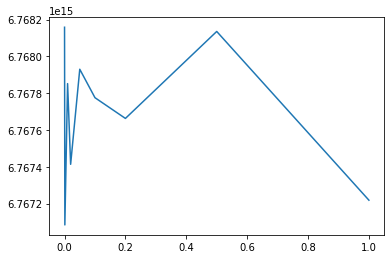

In [ ]:
lr = LassoRegression()
lambda_vals = [0, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
err_vals = []
print(train_Y.shape)
for l in lambda_vals:
  lr.set_lambda(l)
  weights = lr.fit(train_X, train_Y, num_iter=1000)
  y_pred = lr.predict(train_X)
  err = mean_squared_error(train_Y, y_pred)
  err_vals.append(err)

plt.plot(lambda_vals, err_vals)